In [1]:
import json
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy

import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from Utilities import score
from Utilities import plot_matrix_runs, plot_matrix_runs_different_scale, plot_results
from Utilities import Add_ID_Count_Neighbours, PairData

## Exploration of extracted homomorphism counts for ENZYMES

In [2]:
with open('data/homomorphism_counts/ENZYMES_50.homson') as f:
   data_run = json.load(f)

# To extract the homomorphism counts for each of the embeddings
hom_counts_list = np.array([element['counts'] for element in data_run['data']], dtype = 'float')

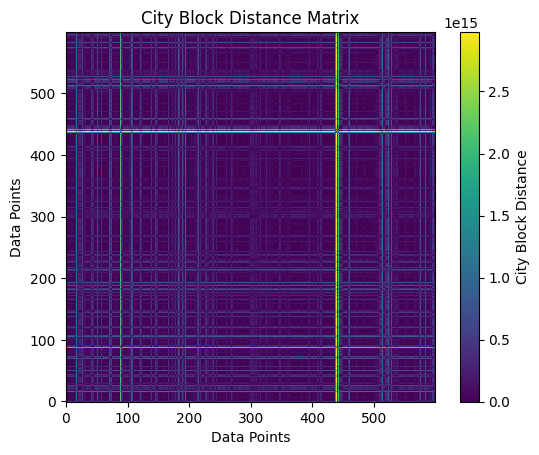

In [3]:
L1_dist = cdist(hom_counts_list, hom_counts_list, metric='cityblock')
plt.imshow(L1_dist, cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label='City Block Distance')
plt.title('City Block Distance Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

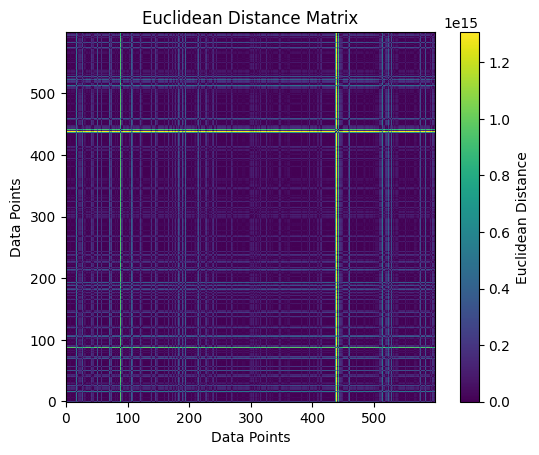

In [4]:
L2_dist = cdist(hom_counts_list, hom_counts_list, metric='euclidean')
plt.imshow(L2_dist, cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label='Euclidean Distance')
plt.title('Euclidean Distance Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

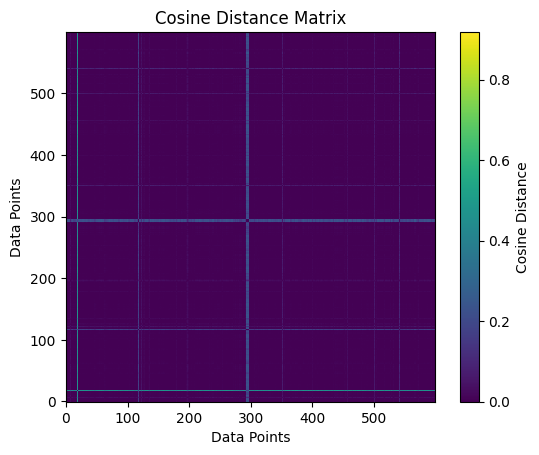

In [5]:
cosine_dist = cdist(hom_counts_list, hom_counts_list, metric='cosine')
plt.imshow(cosine_dist, cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label='Cosine Distance')
plt.title('Cosine Distance Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

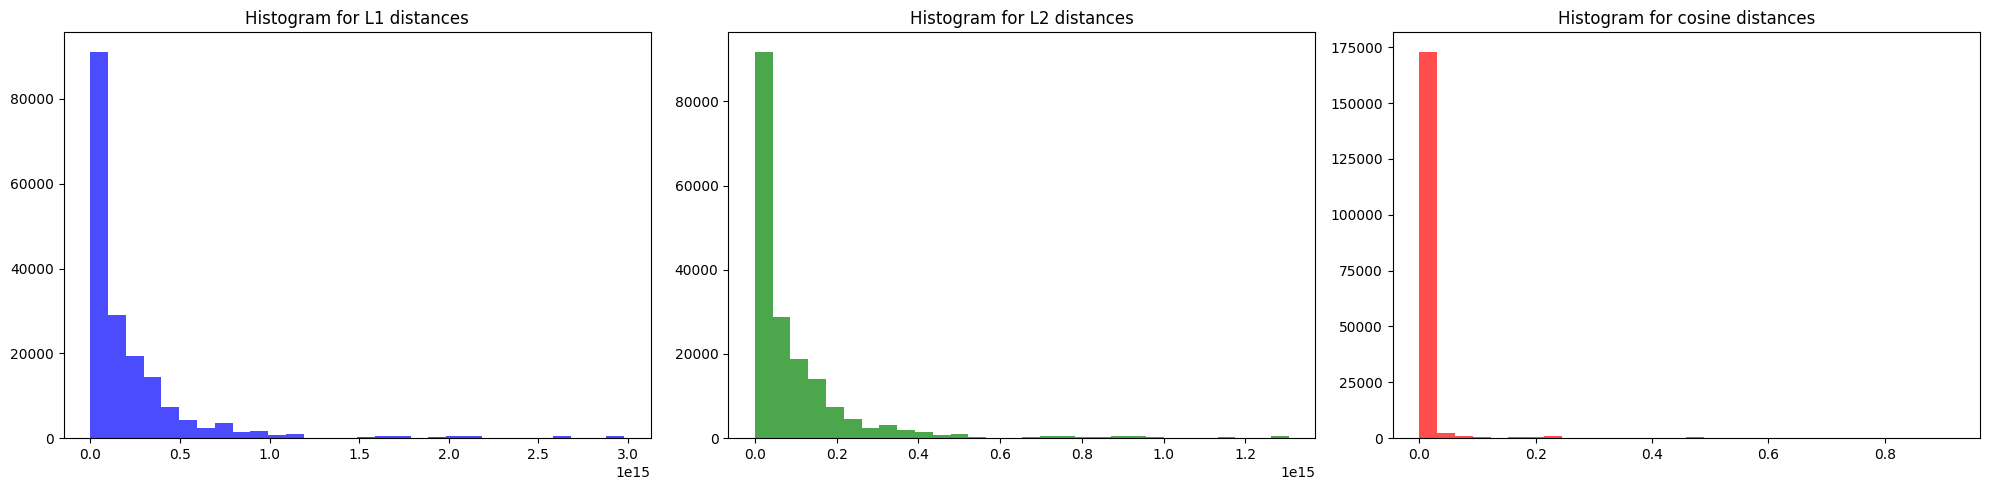

In [6]:
L1_distances = L1_dist[np.triu_indices(len(L1_dist))]
L2_distances = L2_dist[np.triu_indices(len(L2_dist))]
cosine_distances = cosine_dist[np.triu_indices(len(cosine_dist))]

# Create three separate subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot histogram for arr1
axs[0].hist(L1_distances, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram for L1 distances')

# Plot histogram for arr2
axs[1].hist(L2_distances, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram for L2 distances')

# Plot histogram for arr3
axs[2].hist(cosine_distances, bins=30, color='red', alpha=0.7)
axs[2].set_title('Histogram for cosine distances')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

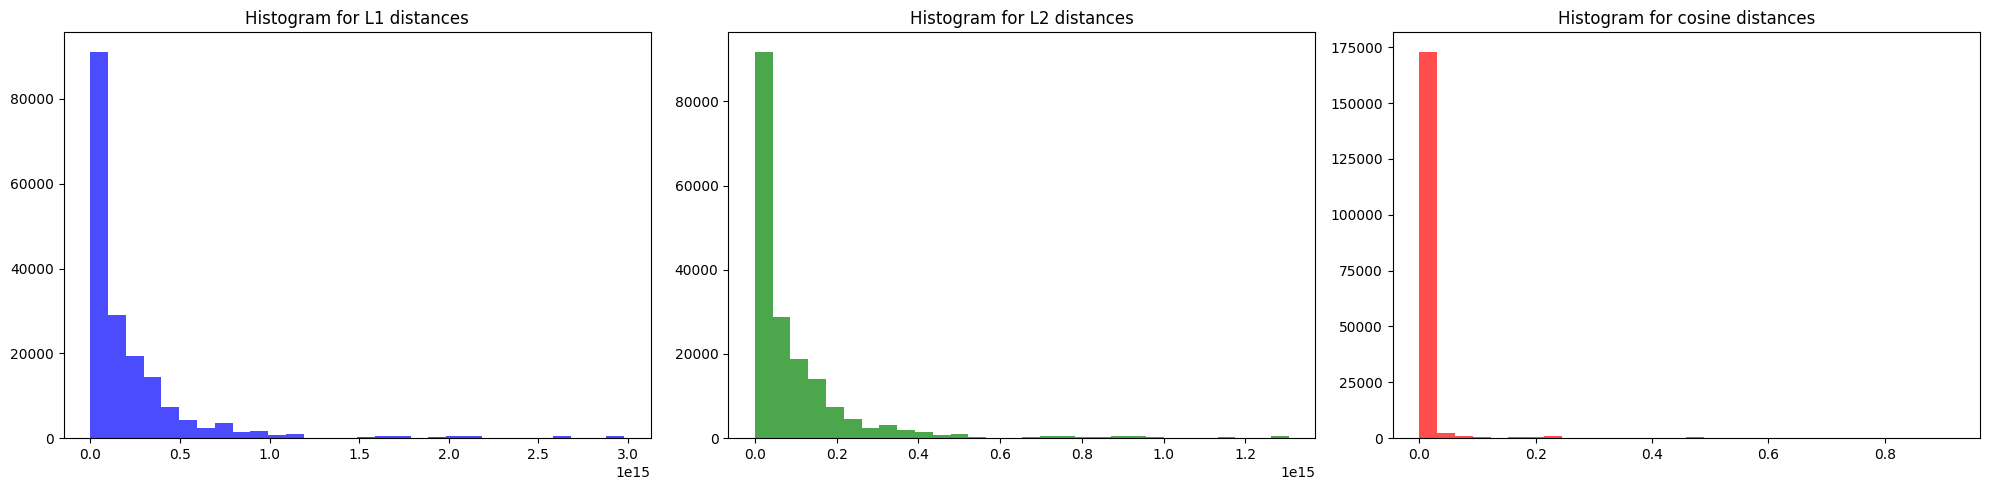

In [7]:
L1_distances = L1_dist[np.triu_indices(len(L1_dist))]
L2_distances = L2_dist[np.triu_indices(len(L2_dist))]
cosine_distances = cosine_dist[np.triu_indices(len(cosine_dist))]

# Create three separate subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot histogram for arr1
axs[0].hist(L1_distances, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram for L1 distances')

# Plot histogram for arr2
axs[1].hist(L2_distances, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram for L2 distances')

# Plot histogram for arr3
axs[2].hist(cosine_distances, bins=30, color='red', alpha=0.7)
axs[2].set_title('Histogram for cosine distances')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

With counts cosine distances also with ENZYMES appear to be very small, however they are already bigger than the ones considered using MUTAG, where the largest one between pairs was in the order of 10^-6.

## Consider count densities instead
$$t(F,G) = \frac{hom(F,G)}{|V(G)|^{V(F)}}$$

In [24]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', pre_transform=Add_ID_Count_Neighbours(), use_node_attr=True)

In [55]:
graph_sizes = [data_run['data'][i]['vertices'] for i in range(len(data_run['data']))] # Contains the number of vertices for each graph in the dataset.
pattern_sizes = data_run['pattern_sizes'] # Contains the patterns sizes for the graphs.
homomorphism_counts = [data_run['data'][i]['counts'] for i in range(len(data_run['data']))]

# Noticed that there are some homomorphism densities which are larger than 1, which should not be the case
wrong_graphs = []
wrong_patterns = []
for i, VG in enumerate(graph_sizes):
    for j, VF in enumerate(pattern_sizes):
        num = homomorphism_counts[i][j]
        den = VG**VF
        if num > den:
            wrong_graphs.append(i)
            wrong_patterns.append(j)

In [56]:
print(set(wrong_graphs)) # Graphs on which we obtain homomorphism densities larger than 1.

{10, 11, 527, 528, 33, 49, 52, 565, 54, 55, 56, 57, 566, 59, 60, 567, 580, 581, 584, 596, 99, 106, 118, 119, 121, 123, 124, 126, 128, 129, 131, 132, 134, 135, 137, 139, 140, 141, 151, 152, 155, 156, 158, 159, 162, 163, 164, 207, 213, 216, 236, 237, 238, 239, 250, 260, 272, 280, 328, 329, 337, 353, 361, 362, 363, 367, 368, 369, 372, 375, 385, 393, 395, 396, 430, 435, 440, 452, 457, 461, 462, 463, 469, 472, 474, 475, 476, 480, 507}


In [57]:
set(wrong_patterns) # Patterns for which we obtain homomorphism densities larger than 1.

{33, 38, 45, 46, 47, 49}

In [51]:
[pattern_sizes[wp] for wp in set(wrong_patterns)] 

[12, 9, 9, 6, 6, 5]

In [12]:
# Assess whether this is due to isolated counts.
isolated_nodes = [dataset[i].has_isolated_nodes() for i in range(len(dataset))]
isolated_id = [id for id, value in enumerate(isolated_nodes) if value]
isolated_id # Contains graphs with isolated nodes => But they do not appear to be the problem, as there are way more.

[37, 117, 294, 295, 296, 500, 540, 599]

Remove for now, so only consider all other patterns.

In [14]:
data_run_write = dcopy(data_run)
indices_to_remove = list(set(wrong_patterns))

# Sort the indices in reverse order before removing elements
indices_to_remove.sort(reverse=True)

for index in indices_to_remove:
    del data_run_write['pattern_sizes'][index]


for i in range(len(data_run_write['data'])):
    for index in indices_to_remove:
        del data_run_write['data'][i]['counts'][index]

In [15]:
json_data = json.dumps(data_run_write)
with open('data/homomorphism_counts/ENZYMES_50_fixed.homson', 'w') as file_write:
    file_write.write(json_data)

In [16]:
for i in range(len(data_run['data'])):
    n_vertices = vertices[i]
    den = [n_vertices**pattern_sizes[j] for j in range(len(pattern_sizes))]
    data_run['data'][i]['scaled_counts'] = [data_run['data'][i]['counts'][j] / den[j] for j in range(len(pattern_sizes))]

In [17]:
# Try the scaled ones
hom_counts_list_counts_density = np.array([element['scaled_counts'] for element in data_run['data']], dtype = 'float')
print(f"Maximum entry in hom counts densities: {np.max(hom_counts_list_counts_density)}")

Maximum entry in hom counts densities: 11955.635706018518


In [18]:
hom_counts_list_counts_density_removed = hom_counts_list_counts_density.copy()
hom_counts_list_counts_density_removed = np.delete(hom_counts_list_counts_density_removed, list(wrong_patterns), axis=1)

## Plot the distances using only the densities within 0 and 1

We ignore the counts for the patterns which lead to homomorphism densities larger than 1, as otherwise we'd have some patterns dominating as in the counts case.

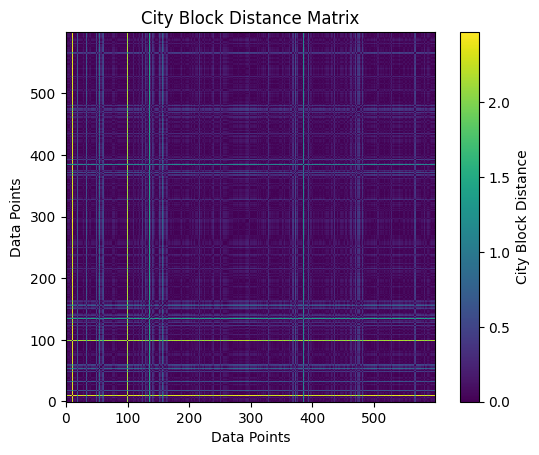

In [19]:
L1_counts_density = cdist(hom_counts_list_counts_density_removed, hom_counts_list_counts_density_removed, metric='cityblock')
plt.imshow(L1_counts_density, cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label='City Block Distance')
plt.title('City Block Distance Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

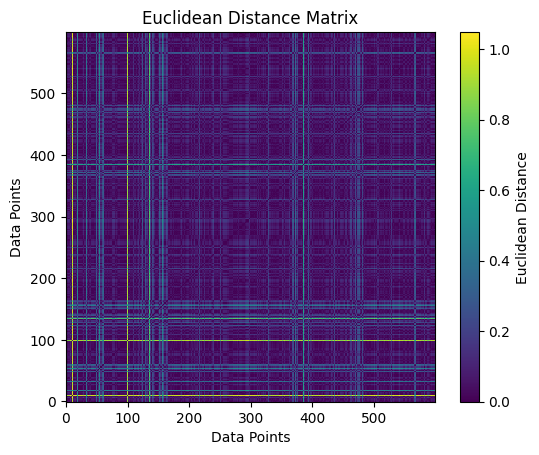

In [20]:
L2_counts_density = cdist(hom_counts_list_counts_density_removed, hom_counts_list_counts_density_removed, metric='euclidean')
plt.imshow(L2_counts_density, cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label='Euclidean Distance')
plt.title('Euclidean Distance Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

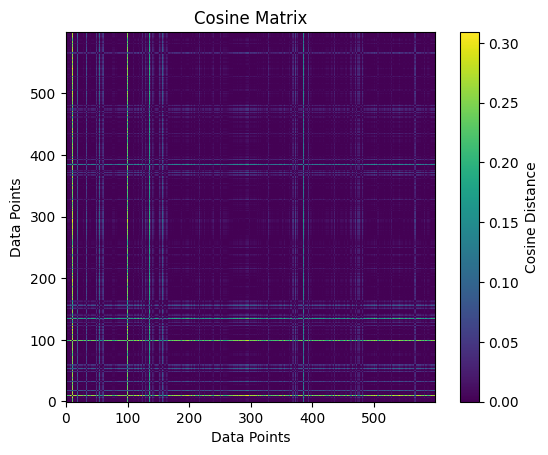

In [21]:
cosine_counts_density = cdist(hom_counts_list_counts_density_removed, hom_counts_list_counts_density_removed, metric='cosine')
plt.imshow(cosine_counts_density, cmap='viridis', origin='lower', interpolation='none')
plt.colorbar(label='Cosine Distance')
plt.title('Cosine Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

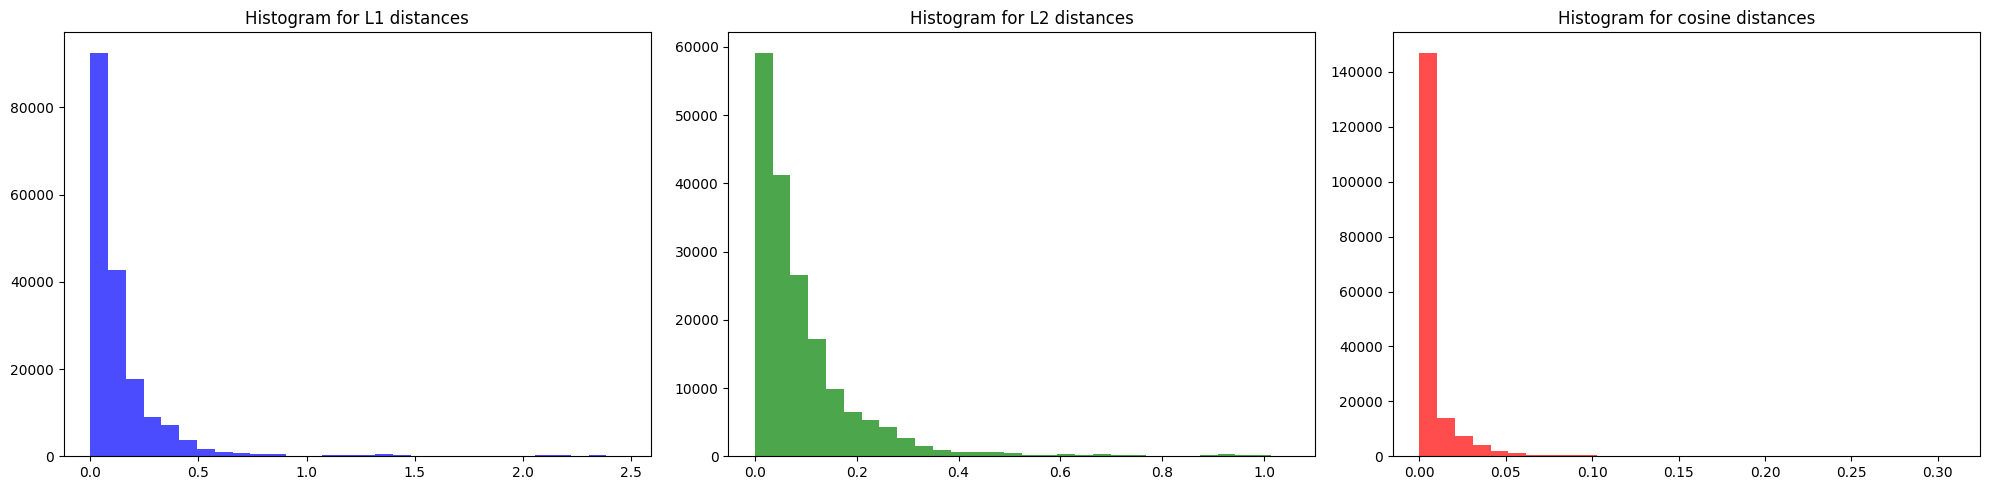

In [22]:
L1_distances = L1_counts_density[np.triu_indices(len(L1_counts_density))]
L2_distances = L2_counts_density[np.triu_indices(len(L2_counts_density))]
cosine_distances = cosine_counts_density[np.triu_indices(len(cosine_counts_density))]

# Create three separate subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot histogram for arr1
axs[0].hist(L1_distances, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram for L1 distances')

# Plot histogram for arr2
axs[1].hist(L2_distances, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram for L2 distances')

# Plot histogram for arr3
axs[2].hist(cosine_distances, bins=30, color='red', alpha=0.7)
axs[2].set_title('Histogram for cosine distances')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

We could apply some transformation to ensure that not all distances are that close to 0.
However, ideally we would like to preserve the distance 0 for those which are identical, so consider a transformation such as square root.

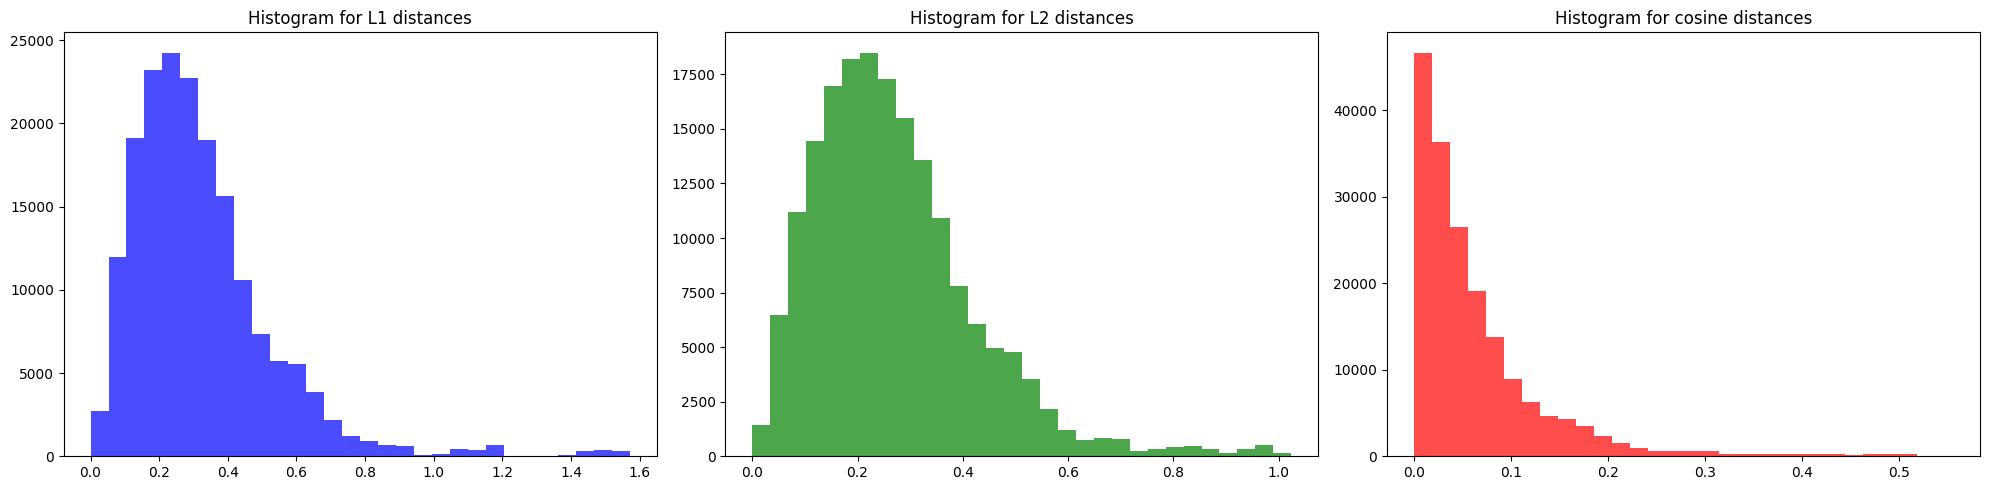

In [25]:
L1_distances = L1_counts_density[np.triu_indices(len(L1_counts_density))]
L2_distances = L2_counts_density[np.triu_indices(len(L2_counts_density))]
cosine_distances = cosine_counts_density[np.triu_indices(len(cosine_counts_density))]

L1_distances = np.sqrt(L1_distances)
L2_distances = np.sqrt(L2_distances)
cosine_distances = np.sqrt(cosine_distances)


# Create three separate subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot histogram for arr1
axs[0].hist(L1_distances, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram for L1 distances')

# Plot histogram for arr2
axs[1].hist(L2_distances, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram for L2 distances')

# Plot histogram for arr3
axs[2].hist(cosine_distances, bins=30, color='red', alpha=0.7)
axs[2].set_title('Histogram for cosine distances')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()